**INPUTS**

In [ ]:
model_loc = "/content/drive/MyDrive/depth/dense_depth_CV/DenseDepth-master/nyu.h5"
input_loc = "/content/drive/MyDrive/depth/New folder/1.jpeg"

**Depth map generation**

In [ ]:
from tensorflow.keras.layers import Layer, InputSpec
import keras.utils.conv_utils as conv_utils
import tensorflow as tf
import keras.backend as K

def normalize_data_format(value):
    if value is None:
        value = K.image_data_format()
    data_format = value.lower()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('The `data_format` argument must be one of '
                         '"channels_first", "channels_last". Received: ' +
                         str(value))
    return data_format


class BilinearUpSampling2D(Layer):
    def __init__(self, size=(2, 2), data_format=None, **kwargs):
        super(BilinearUpSampling2D, self).__init__(**kwargs)
        self.data_format = normalize_data_format(data_format)
        self.size = conv_utils.normalize_tuple(size, 2, 'size')
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
            return (input_shape[0],
                    input_shape[1],
                    height,
                    width)
        elif self.data_format == 'channels_last':
            height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            width = self.size[1] * input_shape[2] if input_shape[2] is not None else None
            return (input_shape[0],
                    height,
                    width,
                    input_shape[3])

    def call(self, inputs):
        input_shape = K.shape(inputs)
        if self.data_format == 'channels_first':
            height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
        elif self.data_format == 'channels_last':
            height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            width = self.size[1] * input_shape[2] if input_shape[2] is not None else None

        return tf.image.resize(inputs, [height, width], method=tf.image.ResizeMethod.BILINEAR)

    def get_config(self):
        config = {'size': self.size, 'data_format': self.data_format}
        base_config = super(BilinearUpSampling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
import numpy as np
from PIL import Image

def DepthNorm(x, maxDepth):
    return maxDepth / x

def predict(model, images, minDepth=10, maxDepth=1000, batch_size=2):
    # Support multiple RGBs, one RGB image, even grayscale
    if len(images.shape) < 3: images = np.stack((images,images,images), axis=2)
    if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    # Compute predictions
    predictions = model.predict(images, batch_size=batch_size)
    # Put in expected range
    return np.clip(DepthNorm(predictions, maxDepth=maxDepth), minDepth, maxDepth) / maxDepth

def load_images(image_files):
    loaded_images = []
    for file in image_files:
        x = np.clip(np.asarray(Image.open( file ), dtype=float) / 255, 0, 1)
        loaded_images.append(x)
    return np.stack(loaded_images, axis=0)

In [ ]:
import cv2

img = cv2.imread(input_loc, cv2.IMREAD_UNCHANGED)

print('Original Dimensions : ',img.shape)

dim = (640, 480)
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
print('Resized Dimensions : ',resized.shape)

#cv2.imshow("Resized image", resized)
cv2.imwrite('input.png',resized)
cv2.waitKey(0)
cv2.destroyAllWindows()

Original Dimensions :  (480, 640, 3)
Resized Dimensions :  (480, 640, 3)


In [ ]:
import os
import glob
import argparse
import matplotlib
from PIL import Image
from skimage.transform import resize
import skimage
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
#from layers import BilinearUpSampling2D
from tensorflow.keras.layers import Layer, InputSpec
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt

# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model(model_loc, custom_objects=custom_objects, compile=False)
print('\nModel loaded ({0}).'.format(model_loc))

# Input images
#inputs = load_images( glob.glob(args.input) )
inputs = load_images( glob.glob('input.png') )
print(type(inputs))
print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))

# Compute results
outputs = predict(model, inputs)

#matplotlib problem on ubuntu terminal fix
#matplotlib.use('TkAgg')

# Display results
print(outputs[0].shape)
plasma = plt.get_cmap('plasma')
rescaled = outputs[0][:,:,0]
rescaled = rescaled - np.min(rescaled)
rescaled = rescaled / np.max(rescaled)
plt.imsave("output.png", resize(plasma(rescaled)[:,:,:3],(480,640)))
plt.show()

Loading model...

Model loaded (/content/drive/MyDrive/depth/dense_depth_CV/DenseDepth-master/nyu.h5).
<class 'numpy.ndarray'>

Loaded (1) images of size (480, 640, 3).
1/1 [==============================] - 3s 3s/step
(240, 320, 1)


In [ ]:
import cv2

img = cv2.imread('output.png', cv2.IMREAD_UNCHANGED)

print('Original Dimensions : ',img.shape)
img = img[:,:,:-1]
#print(img)
print('Original Dimensions : ',img.shape)
cv2.imwrite('output.png',img)
cv2.imwrite('output_2.png',img)

Original Dimensions :  (480, 640, 4)
Original Dimensions :  (480, 640, 3)


True

In [ ]:
#!pip install open3d

**POINT CLOUD**

In [ ]:
import cv2
import matplotlib.pyplot as plt
import open3d as o3d


color_raw = o3d.io.read_image("input.png")
depth_raw = o3d.io.read_image("output.png")
rgbd_img = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw, depth_raw,convert_rgb_to_intensity=False
)
print(rgbd_img)

RGBDImage of size 
Color image : 640x480, with 3 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


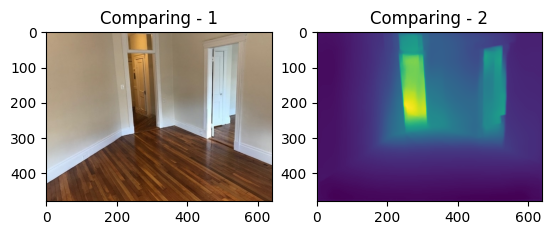

In [ ]:
plt.subplot(1, 2, 1)
plt.title('Comparing - 1')
plt.imshow(rgbd_img.color)
plt.subplot(1, 2, 2)
plt.title('Comparing - 2')
plt.imshow(rgbd_img.depth)
plt.show()

In [ ]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_img,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault
    )
)

pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

PointCloud with 307200 points.

In [ ]:
o3d.io.write_point_cloud("point_cloud_2.ply", pcd)

True

**SURFACE RECONSTRUCTION USING POISSON CONSTRUCTION**

In [ ]:
pcd.estimate_normals()
pcd.orient_normals_to_align_with_direction()
pcd.orient_normals_consistent_tangent_plane(100)

# surface reconstruction
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=12, n_threads=1)[0]

# save the mesh
o3d.io.write_triangle_mesh(f'mesh_2.obj', mesh)

# visualize the mesh
#o3d.visualization.draw_geometries([mesh])

True